# 💻 Vanlige geometriske operasjoner



Geometriske operasjoner refererer til et sett med metoder som kan brukes til å behandle og analysere geometriske objekter, som punkter, linjer og polygoner. Disse operasjonene lar oss for eksempel stille spørsmål om hvordan to eller flere geografiske objekter forholder seg til hverandre: Krysser de, berører eller overlapper de hverandre? Ligger de ved siden av hverandre? Hvor langt fra hverandre er de? Med verktøyene samlet i geopandas er det enkelt å utføre denne typen operasjoner. Når vi fordyper oss i de geometriske operasjonene, vil du oppdage at de danner grunnlaget for mange romlige analyser, og muliggjør innsikt som er ofte vanskelig å skille fra ikke-romlige data alene.

I denne notebooken (inspirert av [Python for Geographic Data Analysis](https://pythongis.org/part2/chapter-06/nb/02-geometric-operations.html)) demonstrerer vi noen av de vanligste geometriske manipulasjonsfunksjonene som er tilgjengelige i geopandas. 

Geometriske manipulasjoner er ofte nyttige f.eks. når vi arbeider med data relatert til administrative grenser, da vi ofte må transformere eller manipulere de geografiske dataene på en eller annen måte for videre analyse og visualiseringsformål. Deretter vil vi lære hvordan du genererer sentroider, forskjellige konturer og buffersoner for polygonene. 

La oss starte med å lese befolkningsdata fra Oslo kommune inn i en `GeoDataFrame`:

In [1]:
import geopandas as gpd
import pathlib 

NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_MAPPE = NOTEBOOK_PATH / "data"

# Les inn dataene og sjekk innholdet
data = gpd.read_file(DATA_MAPPE / "oslo_bydeler" / "oslo_bydeler_befolkning_2024.geojson")
data.head()

,fid,bydelsnr,bynavn,bydel,befolkning_2024,geometry
0,1,030101,Oslo,Gamle Oslo,63721,"MULTIPOLYGON (((10.66087 59.88365, 10.66472 59..."
1,2,030102,Oslo,Grünerløkka,65532,"MULTIPOLYGON (((10.75378 59.91469, 10.75453 59..."
2,3,030103,Oslo,Sagene,47627,"MULTIPOLYGON (((10.77156 59.93095, 10.77135 59..."
3,4,030104,Oslo,St.Hanshaugen,41571,"MULTIPOLYGON (((10.75136 59.91923, 10.75158 59..."
4,5,030105,Oslo,Frogner,60727,"MULTIPOLYGON (((10.65562 59.89038, 10.65381 59..."


For geometriske manipulasjoner er det hovedsakelig geometrikolonnen som inneholder polygongeometriene vi er interesserte i. La oss inspisere hva som er lagret i geometrikolonnen vår:

In [2]:
data["geometry"].head()

0    MULTIPOLYGON (((10.66087 59.88365, 10.66472 59...
1    MULTIPOLYGON (((10.75378 59.91469, 10.75453 59...
2    MULTIPOLYGON (((10.77156 59.93095, 10.77135 59...
3    MULTIPOLYGON (((10.75136 59.91923, 10.75158 59...
4    MULTIPOLYGON (((10.65562 59.89038, 10.65381 59...
Name: geometry, dtype: geometry

In [3]:
# Sjekk datatypen til geometrikolonnen
type(data["geometry"])

geopandas.geoseries.GeoSeries

In [4]:
# Sjekk datatypen til en verdi i geometrikolonnen
type(data["geometry"].values[0])

shapely.geometry.multipolygon.MultiPolygon

La oss plotte geometriene ved å bruke den innebygde `.plot()`-funksjonen i geopandas, og `matplotlib.pyplot` for å fjerne av akselinjer og etiketter:

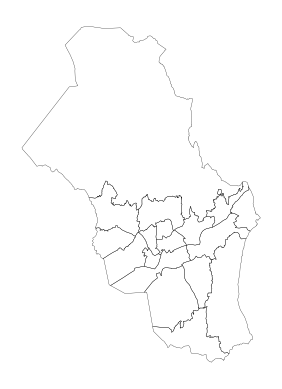

In [5]:
import matplotlib.pyplot as plt

data.plot(facecolor="none", linewidth=0.2)

plt.axis("off")
plt.show()

## Centroid

Sentroiden til en geometri er det geometriske sentrum av en gitt geometri (linje, polygon eller en geometrisamling). Å trekke ut tyngdepunktet til geometriske funksjoner er nyttig i mange tilfeller. Geometriske sentroider kan for eksempel brukes til å plassere tekst i visualiseringer. 

Vi kan trekke ut senterpunktet til hvert polygon via `centroid`-attributtet til `geometri`-kolonnen. Dataene bør ligge i et projisert koordinatreferansesystem ved beregning av tyngdepunktene. Hvis du prøver å beregne centroider basert på informasjon om breddegrad og lengdegrad, vil 'geopandas' advare oss om at resultatene sannsynligvis er (litt) feil. Vår `GeoDataFrame` er i WGS 84 (EPSG:4326) koordinatreferansesystem (CRS), så vi må transformere datasettet før vi kan fortsette med å beregne senterpunktene:

In [6]:
data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
data = data.to_crs(epsg="25832")
data.crs

<Projected CRS: EPSG:25832>
Name: ETRS89 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°E and 12°E: Austria; Denmark - onshore and offshore; Germany - onshore and offshore; Italy - onshore and offshore; Norway including Svalbard - onshore and offshore; Spain - offshore.
- bounds: (6.0, 36.53, 12.01, 84.01)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Nå kan vi finne senterpunktet for alle bydelene:

In [8]:
data["geometry"].centroid.head()

0    POINT (597377.326 6641206.893)
1    POINT (599366.765 6644407.533)
2    POINT (598598.518 6645843.574)
3     POINT (597215.91 6644759.766)
4    POINT (594561.285 6642429.531)
dtype: geometry

Vi kan også bruke metoden direkte på `GeoDataFrame` for å oppnå samme resultat ved å bruke syntaksen `data.centroid`. Samtidig kan vi også plotte sentroidene for en visuell sjekk:

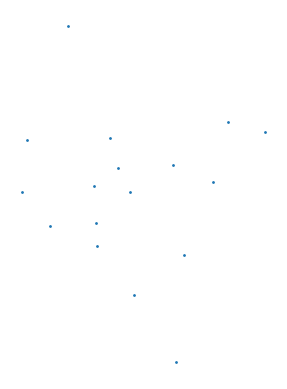

In [9]:
data.centroid.plot(markersize=1)

plt.axis("off")
plt.show()

## Unær forening (Unary union)

En unær foreningsoperasjon (unarry uion) kombinerer flere geometriske objekter til en enkelt, enhetlig geometrisk form. Vi kan generere en felles skisse for forvaltningsområdene gjennom å skape en geometrisk forening mellom alle geometrier. Dette kan være nyttig for eksempel for å visualisere konturene av et studieområde. `unary_union` (eller `union_all()` i senere versjoner av GeoPandas) returnerer et enkelt geometriobjekt, som automatisk visualiseres når koden kjøres i en Jupyter Notebook:

/tmp/ipykernel_10738/3582404833.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  data.unary_union


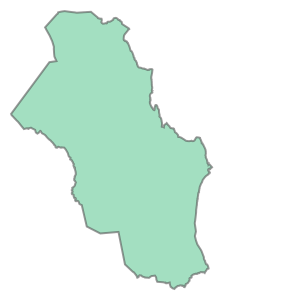

In [10]:
data.unary_union

`.unary_union` returnerer et `shapely` polygonobjekt ut av resultatene. Det er også mulig å slå sammen geometrier ved å bruke en metode kalt `.dissolve()` som returnerer en `GeoDataFrame` som output (med aggregert attributtinformasjon). 

Vi kan teste hvordan vi kan oppløse skillene mellom ulike polygoner med `dissolve()`:

In [11]:
# Slå sammen geometrier ved hjelp av dekningsalgoritme
dissolved = data.dissolve()
dissolved.head()

,geometry,fid,bydelsnr,bynavn,bydel,befolkning_2024
0,"POLYGON ((596180.487 6638937.796, 594552.141 6...",1,030101,Oslo,Gamle Oslo,63721


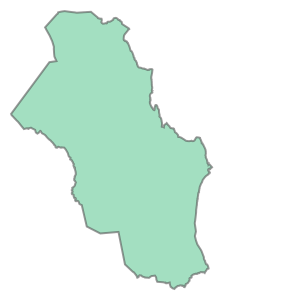

In [12]:
# Få shapely geometrien
dissolved.geometry[0]

Som et resultat inneholder "dissolved"-variabelen nå den sammenslåtte geometrien så vel som attributtinformasjonen knyttet til den. Når vi ser på den returnerte geometrien, kan vi se at den er identisk med den som returneres av `.unary_union`-metoden. Legg merke til at som standard lagrer `.dissolve()` ganske enkelt den første raden med data som en attributtinformasjon. Det er imidlertid mulig å kontrollere hvordan attributtinformasjonen skal aggregeres/oppsummeres, f.eks. ved å summere verdiene.


## Avgrensende polygon (Bounding box)

Et avgrensende polygon (bounding box), eller konvolutt, er det minste rektangulære polygonet som omslutter en gitt geometri eller et sett med geometrier. Det som å tegne et tettest mulig rektangel rundt en form, og fange alle punktene innenfor dette rektangelet. Det avgrensende polygonet brukes ofte i romlige operasjoner for midlertidig filtrering fordi det gir en beregningsmessig enkel måte å teste for mulige skjæringspunkter eller nærheter mellom geometrier som kan brukes til å velge data. Det er forskjellige måter å trekke ut et avgrensende polygon for en gitt geometri/geometrier, for eksempel aksejustert *envelope*, *minimum rotated rectangle* og *minimum bounding circle* som alle kan trekkes ut med `geopandas`.

I en "GeoDataFrame" kan vi enkelt returnere det minimale aksejusterte begrensningsrektangelet for geometrier ved å bruke .envelope-attributtet som returnerer det avgrensende rektangelet for hver geometri:

In [13]:
data.envelope.head()

0    POLYGON ((592958.353 6638799.23, 601608.059 66...
1    POLYGON ((597727.614 6643080.669, 601054.083 6...
2    POLYGON ((597670.167 6644702.469, 599605.593 6...
3    POLYGON ((595869.706 6642989.209, 598242.081 6...
4    POLYGON ((592067.262 6639619.027, 597020.734 6...
dtype: geometry

For å få det avgrensende rektangelet for hele laget, lager vi først en forening av alle geometrier ved å bruke `.unary_union`, og trekker deretter ut det avgrensende rektangelet for det polygonet ved å bruke `.envelope`:

/tmp/ipykernel_10738/1587892062.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  data.unary_union.envelope


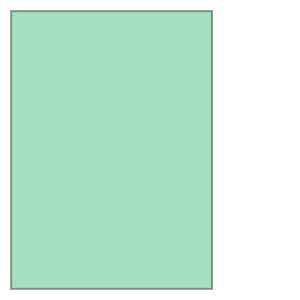

In [14]:
data.unary_union.envelope

Hjørnekoordinater til avgrensningsboksen for en "GeoDataFrame" kan hentes via attributtet "total_bounds":

In [15]:
data.total_bounds

array([ 583014.23573992, 6631633.09927682,  609000.16402367,
       6667559.668596  ])

"bounds"-attributtet returnerer de avgrensende koordinatene for hver rad:

In [16]:
data.bounds.head()

,minx,miny,maxx,maxy
0,592958.353481,6.638799e+06,601608.058818,6.644175e+06
1,597727.614206,6.643081e+06,601054.083213,6.645802e+06
2,597670.166569,6.644702e+06,599605.593389,6.646966e+06
3,595869.705791,6.642989e+06,598242.081439,6.646343e+06
4,592067.262020,6.639619e+06,597020.733515,6.645462e+06


På samme måte er det mulig å få *minimum rotated rectangle* og *minimum bounding circle* med `geopandas` ved å bruke henholdsvis `.minimum_rotated_rectangle()` og `.minimum_bounding_circle()` metodene. Her slår vi først sammen alle geometriene ved å bruke `.dissolve()`-metoden som vist tidligere, og bruker deretter den sammenslåtte geometrien for å få minimumsgrensende polygon:

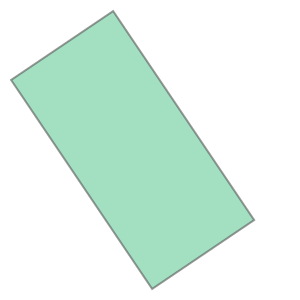

In [17]:
data.dissolve().minimum_rotated_rectangle().geometry[0]

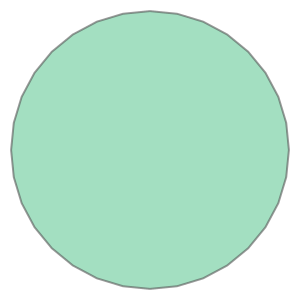

In [18]:
data.dissolve().minimum_bounding_circle().geometry[0]

Som man kan se fra geometriene ovenfor, kan *minimum rotated rectangle* rotere rundt inputgeometriene og har som mål å omslutte dem så tett som mulig. *Minimumssirkelen* skaper igjen en sirkel rundt geometriene på en måte som gjør at hver geometri er omsluttet av sirkelen. Avhengig av brukstilfellet kan alle disse metodene være nyttige når du arbeider med geografiske data.

### Konvekst skrog (Convex hull)

En litt mer detaljert avgrensning av datautstrekningen kan trekkes ut ved å bruke et konvekst skrog (Convex hull) som representerer det minste mulige polygonet som inneholder alle punktene i et objekt. For å illustrere dette, se for deg å strekke en gummistrikk rundt et sett med punkter. Når den er sluppet, vil gummibåndet smekke inn i formen til det konvekse skroget, som vikler seg rundt de ytterste punktene. Dermed utelukker den punkter som er "innrykk" i formen. I geoberegning brukes det konvekse skroget til ulike oppgaver da det enkelt kan gi en forenklet representasjon av et sett med punkter eller en mer kompleks geometri.

I geopandas kan vi bruke et attributt `.convex_hull` for å returnere det konvekse skroget av geometrier. På samme måte som med unær forening, hvis vi bruker den konvekse skrogmetoden på hele `GeoDataFrame`, vil vi få en GeoSeries som inneholder et konveks skrog for hver polygon separat:

In [19]:
data.convex_hull.head()

0    POLYGON ((594552.141 6638799.23, 592958.353 66...
1    POLYGON ((598312.869 6643080.669, 598275.79 66...
2    POLYGON ((597806.842 6644702.469, 597799.792 6...
3    POLYGON ((597632.438 6642989.209, 597425.735 6...
4    POLYGON ((592958.353 6639619.027, 592800.232 6...
dtype: geometry

For å lage et konvekst skrog for hele utstrekningen, må vi først lage en forening av alle polygoner.

/tmp/ipykernel_10738/2590583862.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  data.unary_union.convex_hull


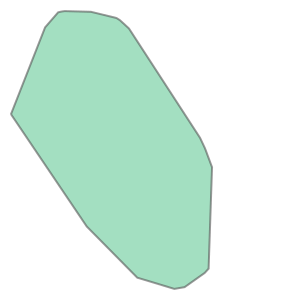

In [20]:
data.unary_union.convex_hull

## Forenkling av geometrier

Geometrisk forenkling er en nyttig prosess, spesielt når du visualiserer data som inneholder svært detaljerte geometrier. Geopandas har en funksjon kalt `.simplify()` som er en annen måte å forenkle geometrier på. `tolerance`-parameteren kan brukes til å kontrollere nivået av forenkling. Enhetene for denne parameteren følger inputkoordinatene. Dette betyr at f.eks. med `tolerance=1000` står toleransen for 1000 meter fordi våre inndata er i et projisert (metrisk) koordinatsystem. Imidlertid, i tilfelle inputdataene ville ha lat/lon-koordinater, bør toleransen angis som desimalgrader.

In [21]:
data.simplify(tolerance=1000).head()

0    POLYGON ((592958.353 6639619.027, 597699.868 6...
1    POLYGON ((598065.701 6643209.117, 598489.114 6...
2    POLYGON ((599011.568 6645045.884, 597799.792 6...
3    POLYGON ((597917.398 6643711.35, 597632.438 66...
4    POLYGON ((592645.812 6640361.375, 592067.262 6...
dtype: geometry

På lignende måte som før, kan vi enkelt bruke `.simplify()` på omfanget av alle geometrier ved først å få den unære unionen av inngangsgeometriene:

/tmp/ipykernel_10738/2994218581.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  data.unary_union.simplify(tolerance=1000)


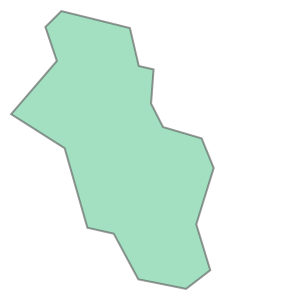

In [22]:
data.unary_union.simplify(tolerance=1000)

## Buffer

En buffer refererer til en geometrisk operasjon som skaper en sone rundt en gitt geometri (eller geometrier), som vanligvis representerer en viss avstand fra formen. Denne sonen/bufferen kan visualiseres som et utvidet område rundt den opprinnelige formen, eller omvendt, et sammentrukket område inne i formen hvis bufferavstanden er negativ. Bufring er en vanlig romlig operasjon som har et mangfold av brukstilfeller i romlige analyser. For eksempel i transportnettanalyser er det greit å hente transportnettet også fra utenfor undersøkelsesområdet for å fange opp ruter som går utover undersøkelsesområdegrensen.

I geopandas kan vi enkelt lage buffere ved å bruke metoden `.buffer()` som kan brukes på alle geometrier samtidig på samme måte som våre tidligere eksempler. Parameteren `distance` i funksjonen `.buffer()` definerer radiusen til bufferen (i henhold til koordinatsystemet til dataene). I det følgende vil vi bruke en 1000 meter buffer på hele 'GeoDataFrame'-en som vil produsere separate buffere for hver bydel:

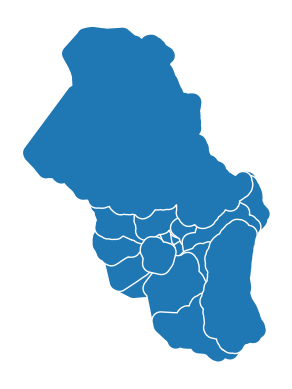

In [23]:
# 1000 m buffer for hver polygon
data.buffer(1000).plot(edgecolor="white")

plt.axis("off")
plt.show()

Hvis vi bare vil ha én buffer for hele området, må vi først kombinere geometriene til ett objekt før bufferanalysen:

/tmp/ipykernel_10738/2658296095.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  data.unary_union.buffer(1000)


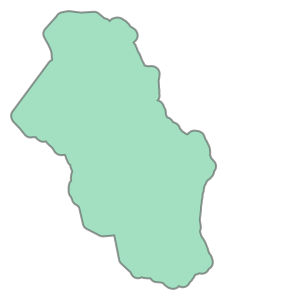

In [24]:
# 1000 m buffer for hver polygon
data.unary_union.buffer(1000)

Buffer kan brukes med forskjellige geometrityper, også med `Point` og `LineString` objekter. Det er nyttig å legge merke til at hvis du bruker en buffer for punkter eller polygoner, vil den resulterende geometrien alltid være en "polygon".

## Oppløsning og sammenslåing av geometrier

Aggregering av romlige data refererer til å kombinere geometrier til grovere romlige enheter basert på noen attributter. Prosessen kan også omfatte beregning av sammendragsstatistikk. I `geopandas` er det en metode kalt `.dissolve()` som grupperer dataene basert på en spesifikk attributtkolonne og deretter produserer en forening av geometriene for hver gruppe i det attributtet. Samtidig kan vi også få oppsummerende statistikk over attributtene.

For å demonstrere hvordan dissolve fungerer med dataene våre, la oss lage en ny kolonne i 'GeoDataFrame'-en for å indikere bydeler med befolkningstetthet over gjennomsnittet. 
La oss først regne ut arealet for hver bydel, og deretter befolkningstettheten.



In [25]:
# Legge til en ny kolonne hvor vi regner ut arealet
data['areal_km2'] = data.area / 1000000

# Regne ut befolkningstetthet i ny kolonne
data["befolkningstetthet"] = data["befolkning_2024"] / data["areal_km2"]

# La oss også proppe radene med 0 i "befolkning_2024"
data = data[data["befolkning_2024"] != 0]


Vi kan nå legge til en ny tom kolonne "tetthet" og legge til verdier som indikerer over og under gjennomsnittlig befolkningstetthet per bydel:

In [26]:
# Opprett en ny kolonne og legg til en konstant verdi
data["tetthet"] = 0
# Filtrer rader med befolkningstetthet over gjennomsnittet og oppdater kolonnen "tetthet"
data.loc[data["befolkningstetthet"] > data["befolkningstetthet"].mean(), "tetthet"] = 1

Etter dette steget skal vi ha flere rader med tallene `0` og `1`, der tallet én indikerer et tett befolket område. Vi kan enkelt sjekke hvor mange tettbefolkede bydeler vi fikk ved å bruke `.value_counts()`-metoden fra pandas:

In [27]:
data.tetthet.value_counts()

tetthet
0    12
1     3
Name: count, dtype: int64

Nå kan vi bruke denne `tetthet`-kolonnen til å løse opp dataene i to grupper ved å bruke `.dissolve()`-funksjonen. Samtidig kan vi summere verdiene i `befolkningstetthet` og `areal_km2`-kolonnene ved å bruke `aggfunc`-parameteren. Aggregeringen krever at vi velger de numeriske kolonnene som vi ønsker å inkludere i utdataene (som er indikert med listen over kolonnenavn nedenfor):

In [28]:
# Gjennomfør aggregeringen
dissolved = data[["befolkningstetthet", "areal_km2", "tetthet", "geometry"]].dissolve(
    by="tetthet", aggfunc="sum"
)
dissolved

,geometry,befolkningstetthet,areal_km2
tetthet,,,
0,"POLYGON ((597476.464 6636124.511, 597418.256 6...",44039.585468,165.315120
1,"POLYGON ((599611.114 6645693.453, 599631.948 6...",40729.377738,11.438882


De oppløste dataene skal ha like mange rader med data som det var unike verdier i kolonnen - én rad for hver unike verdi. Dataene våre har blitt komprimert til to geometriske objekter, og kolonnen som brukes for å løse opp dataene kan nå finnes i indeksen. Attributtkolonnene representerer summen av verdiene per gruppe. Vi kan tilbakestille indeksen og sette inn den kategoriske informasjonen i en ny kolonne, hvoretter vi kan gjøre en rask visualisering av resultatet:

In [29]:
dissolved = dissolved.reset_index()

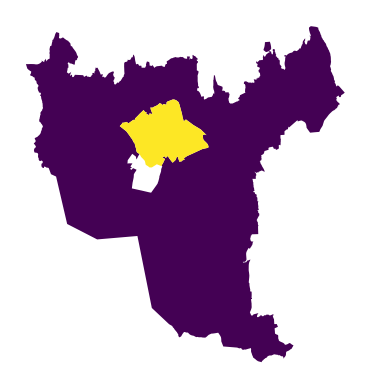

In [30]:
dissolved.plot(column="tetthet")

plt.axis("off")
plt.show()

## Endre den aktive geometrien i en GeoDataFrame

I de forrige eksemplene lagret vi egentlig ikke de manipulerte geometriene noe sted, vi har stort sett skrevet ut eller plottet resultatene av de geometriske operasjonene direkte.

I noen tilfeller, som når vi beregnet sentroidene i de forrige eksemplene, vil vi faktisk lagre sentroidene i en GeoDataFrame. Det kan være nyttig fordi man da kan fortsette å behandle eller analysere dataene basert på disse geometriene. Å lagre og oppdatere geometriene i en GeoDataFrame kan gjøres enkelt med geopandas, og faktisk kan du ha flere kolonner som inneholder geometriske objekter. Det finnes flere tilnærminger for å oppdatere geometriene i en GeoDataFrame:

1. Overskriv de eksisterende geometriene i geometrikolonnen ved å lagre de nye (manipulerte) geometriene i den.

2. Opprett en ny kolonne (f.eks. centroid) og lagre de nye geometriene i denne. Deretter aktiverer/setter du denne kolonnen som den "aktive geometrien" for din GeoDataFrame. På denne måten kan du ha flere kolonner samtidig som inneholder geometriske objekter i en GeoDataFrame, noe som kan være veldig praktisk!

Noen viktige bemerkninger om disse tilnærmingene: Alternativ 1 er veldig enkelt å gjøre, men ulempen med det er at du ikke lenger har tilgang til de opprinnelige geometriene (f.eks. polygoner). Alternativ 2 krever et par trinn, men fordelen med det er at du enkelt kan bytte mellom de opprinnelige geometriene og sentroidene i dataene dine. Imidlertid, når du lagrer de geografiske dataene på disk, kan du i de fleste tilfeller bare inkludere én kolonne med geometriske objekter. Derfor må du senest på dette stadiet bestemme hvilken kolonne som skal brukes til å representere de geometriske objektene i dataene dine.

In [31]:
# Lag en kopi av de originale dataene
alternativ_1 = data.copy()
alternativ_1["geometry"].head(2)

0    MULTIPOLYGON (((592958.353 6639619.027, 593170...
1    MULTIPOLYGON (((598065.701 6643209.117, 598106...
Name: geometry, dtype: geometry

In [32]:
# Oppdater geometrikolonnen men senterpunktene
alternativ_1["geometry"] = alternativ_1.centroid
print(alternativ_1.head(2))

   fid bydelsnr bynavn        bydel  befolkning_2024  \
0    1   030101   Oslo   Gamle Oslo            63721   
1    2   030102   Oslo  Grünerløkka            65532   

                         geometry  areal_km2  befolkningstetthet  tetthet  
0  POINT (597377.326 6641206.893)  15.273315         4172.047829        0  
1  POINT (599366.765 6644407.533)   4.754232        13783.928465        1  


Her ble polygonene i geometrikolonnen erstattet og fylt med punktobjekter som representerer sentroidene til polygonene. Med denne tilnærmingen har vi nå slettet de opprinnelige polygongeometriene.

Det andre alternativet er å opprette en ny kolonne for å lagre sentroidene og deretter bruke denne kolonnen som kilden for å representere geometriene til den gitte GeoDataFrame:

In [33]:
# Lag en kopi av de originale dataene og lat en kolonne med sentroidene
alternativ_2 = data.copy()
alternativ_2["centroid"] = data.centroid
alternativ_2.head(2)

,fid,bydelsnr,bynavn,bydel,befolkning_2024,geometry,areal_km2,befolkningstetthet,tetthet,centroid
0,1,030101,Oslo,Gamle Oslo,63721,"MULTIPOLYGON (((592958.353 6639619.027, 593170...",15.273315,4172.047829,0,POINT (597377.326 6641206.893)
1,2,030102,Oslo,Grünerløkka,65532,"MULTIPOLYGON (((598065.701 6643209.117, 598106...",4.754232,13783.928465,1,POINT (599366.765 6644407.533)


Nå har vi en GeoDataframe med både en kolonne som heter `geometry` og en som heter `centroid`. Begge inneholder geometriobjekter, men som standard bruker GeoPandas alltid `geometry`-kolonnen som den aktive geometrikolonnen.

Men vi kan enkelt velge hviken kolonne som skal være den aktive geometrikolonnen ved å bruke metoden `.set_geometry()`

In [34]:
# Velg sentroide-kolonnen som den aktive geometrikolonnen
alternativ_2 = alternativ_2.set_geometry("centroid")
alternativ_2.head(2)


,fid,bydelsnr,bynavn,bydel,befolkning_2024,geometry,areal_km2,befolkningstetthet,tetthet,centroid
0,1,030101,Oslo,Gamle Oslo,63721,"MULTIPOLYGON (((592958.353 6639619.027, 593170...",15.273315,4172.047829,0,POINT (597377.326 6641206.893)
1,2,030102,Oslo,Grünerløkka,65532,"MULTIPOLYGON (((598065.701 6643209.117, 598106...",4.754232,13783.928465,1,POINT (599366.765 6644407.533)


Dataene ser nå helt like ut, men vi kan se nærmere på `.geometry.name`-attributtet til GeoDataFramen for å se hvilken kolonnne som faktisk blir brukt som den aktive geometrikolonnen:

In [35]:
alternativ_2.geometry.name

'centroid'

Og vi kan også plotte GeoDataFramen for å inspisere det visuelt:

<Axes: >

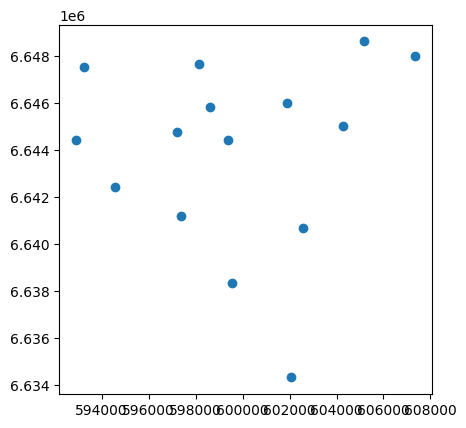

In [36]:
alternativ_2.plot()